In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import get_data
import statsmodels
from simulate import cholesky
from simulate import simulatedata
from simulate import simulate_multiple_time_series

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
syms = ['BTCUSDT']
freq = '10min'
start_date = '2020-01-01'
end_date = '2020-01-03'

In [4]:
raw_data = get_data.get_data(syms, freq, start_date, end_date)
raw_data

BTCUSDT_2019-12-26.json
Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=695704595703-kho1v4q5lhtoqq268ckb4it0n08facat.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.
BTCUSDT_2020-01-02.json


C:\Users\user\Documents\GitHub\TradingBot\get_data.py:52: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  data[symbol] = _fit_data_to_df(data[symbol], frequency)[start_time:end_time]


{'BTCUSDT':                               open     high      low    close      volume  \
 time                                                                        
 2020-01-01 00:00:00+00:00  7195.24  7196.25  7178.20  7191.07  154.874358   
 2020-01-01 00:10:00+00:00  7193.15  7193.53  7177.35  7178.29   80.261439   
 2020-01-01 00:20:00+00:00  7177.71  7185.56  7175.47  7178.45   96.049725   
 2020-01-01 00:30:00+00:00  7178.19  7185.44  7176.23  7177.53   59.973326   
 2020-01-01 00:40:00+00:00  7177.14  7182.99  7176.34  7182.94   44.872982   
 ...                            ...      ...      ...      ...         ...   
 2020-01-02 23:20:00+00:00  6959.16  6962.39  6950.00  6962.34  217.262815   
 2020-01-02 23:30:00+00:00  6962.47  6974.75  6957.66  6965.37  145.757951   
 2020-01-02 23:40:00+00:00  6965.09  6969.46  6959.87  6967.41   75.157310   
 2020-01-02 23:50:00+00:00  6967.40  6968.82  6961.24  6965.71   82.459841   
 2020-01-03 00:00:00+00:00  6965.49  6965.71  6948.45

In [5]:
dt = pd.DataFrame()
dt['close'] = raw_data['BTCUSDT']['close']
dt['high'] = raw_data['BTCUSDT']['high']
dt['low'] = raw_data['BTCUSDT']['low']
dt['open'] = raw_data['BTCUSDT']['open']
dt.iloc[150]

close    7202.09
high     7211.16
low      7201.58
open     7211.04
Name: 2020-01-02 01:00:00+00:00, dtype: float64

In [6]:
dt1 = pd.DataFrame()
dt1['close'] = dt['close'].pct_change()
dt1['open'] = dt['open'].pct_change()
dt1

,close,open
time,,
2020-01-01 00:00:00+00:00,NaN,NaN
2020-01-01 00:10:00+00:00,-0.001777,-0.000290
2020-01-01 00:20:00+00:00,0.000022,-0.002146
2020-01-01 00:30:00+00:00,-0.000128,0.000067
2020-01-01 00:40:00+00:00,0.000754,-0.000146
...,...,...
2020-01-02 23:20:00+00:00,0.000457,-0.001664
2020-01-02 23:30:00+00:00,0.000435,0.000476
2020-01-02 23:40:00+00:00,0.000293,0.000376


In [7]:
#cách 1
#Nhân chol 1 lần
chol = cholesky.cholesky2(dt) 
inverse_chol = np.linalg.inv(chol)
chol

array([[ 1.        ,  0.        ],
       [-0.09305344,  0.99566112]])

In [8]:
order_close, seasonal_order_close = simulatedata.get_order(dt1['close'][1:])
order_open, seasonal_order_open = simulatedata.get_order(dt1['open'][1:])
order_close, seasonal_order_close, order_open, seasonal_order_open
if sum(seasonal_order_close) == 1: seasonal_order_close = (0, 0, 0, 0)
model_params_close = simulatedata.fit_sarima(dt1['close'][1:], order_close, seasonal_order_close)
if sum(seasonal_order_open) == 1: seasonal_order_open = (0, 0, 0, 0)
model_params_open = simulatedata.fit_sarima(dt1['open'][1:], order_open, seasonal_order_open)
t_close = simulatedata.simulate_sarima(dt1['close'][1:], order_close, seasonal_order_close, model_params_close, len(dt1), 1)
t_open = simulatedata.simulate_sarima(dt1['open'][1:], order_open, seasonal_order_open, model_params_open, len(dt1), 1)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [9]:
dt2 = pd.DataFrame()
dt2['close'] = t_close
dt2['open'] = t_open
dt2
dt3 = simulate_multiple_time_series.normalize_or_standardize_data(dt2['open'], is_normalize= False)
dt4 = simulate_multiple_time_series.normalize_or_standardize_data(dt2['close'], is_normalize= False)
dt3 = np.append(dt3, dt4)
dt3 = np.reshape(dt3, (2, len(dt4)))
dt3

array([[ 1.56876047, -1.15611649,  2.05617236, -0.37924333,  1.13310104,
        -0.38170396,  0.15207685,  0.27272708,  0.10038627,  1.56788004,
        -0.58024428, -0.12471609, -0.78191908, -1.46815807,  0.01549636,
        -0.44957497, -0.62759946,  1.30976487, -1.29325387,  0.38709809,
        -0.60941623,  0.2086201 , -0.06508584,  1.35975361, -1.22315335,
         0.99861786,  0.74806776,  1.89882417,  0.51118379,  1.78351598,
        -0.8557713 , -0.51326679,  1.68843138, -1.22730286,  1.46399443,
        -2.45264026,  0.12560396,  1.42253505,  1.18606951, -0.31823544,
         0.31241012, -1.86015957,  0.22035928, -0.35069837,  1.94398031,
         0.7810516 , -0.67930775,  0.90353217,  0.35955907,  1.90795471,
         1.82145553,  0.95406573, -0.29687211,  0.26602057,  0.33255754,
         0.54880429, -1.32199156,  0.41595224, -1.48348651, -0.64389319,
        -0.10168027, -1.13721703,  0.24219258, -0.54245533,  0.14127985,
        -0.29257913,  0.76824159,  0.08761897, -0.2

In [10]:
dt3 = np.matmul(inverse_chol , dt3)
dt3[0], dt3[1]

(array([ 1.56876047, -1.15611649,  2.05617236, -0.37924333,  1.13310104,
        -0.38170396,  0.15207685,  0.27272708,  0.10038627,  1.56788004,
        -0.58024428, -0.12471609, -0.78191908, -1.46815807,  0.01549636,
        -0.44957497, -0.62759946,  1.30976487, -1.29325387,  0.38709809,
        -0.60941623,  0.2086201 , -0.06508584,  1.35975361, -1.22315335,
         0.99861786,  0.74806776,  1.89882417,  0.51118379,  1.78351598,
        -0.8557713 , -0.51326679,  1.68843138, -1.22730286,  1.46399443,
        -2.45264026,  0.12560396,  1.42253505,  1.18606951, -0.31823544,
         0.31241012, -1.86015957,  0.22035928, -0.35069837,  1.94398031,
         0.7810516 , -0.67930775,  0.90353217,  0.35955907,  1.90795471,
         1.82145553,  0.95406573, -0.29687211,  0.26602057,  0.33255754,
         0.54880429, -1.32199156,  0.41595224, -1.48348651, -0.64389319,
        -0.10168027, -1.13721703,  0.24219258, -0.54245533,  0.14127985,
        -0.29257913,  0.76824159,  0.08761897, -0.2

In [11]:
var_close = simulate_multiple_time_series.compute_std(dt2['close'])
mean_close = dt2['close'].mean()
var_open = simulate_multiple_time_series.compute_std(dt2['open'])
mean_open = dt2['open'].mean()
transform_x_chol = pd.DataFrame()
transform_x_chol['close'] = dt3[1]
transform_x_chol['open'] = dt3[0]
transform_back = pd.DataFrame()
transform_back['open'] = dt3[0] * var_open + mean_open
transform_back['close'] = dt3[0] * var_close + mean_close
# transform_back['open'] = simulate_multiple_time_series.mulback_cholesky(transform_x_chol['open'],  False, var_open, mean_open)
# transform_back['close'] = simulate_multiple_time_series.mulback_cholesky(transform_x_chol['close'],  False, var_close, mean_close)
transform_back 

,open,close
0,0.002279,0.001980
1,-0.001659,-0.001703
2,0.002983,0.002639
3,-0.000536,-0.000653
4,0.001649,0.001391
...,...,...
284,-0.000348,-0.000477
285,-0.000061,-0.000208
286,-0.000015,-0.000166
287,-0.003122,-0.003072


In [12]:
simulated_price_data = pd.DataFrame()
simulated_price_data['close'] = simulatedata.construct_price_series(transform_back['close'], dt['close'][0], dt.index[0], freq)
simulated_price_data['open'] = simulatedata.construct_price_series(transform_back['open'], dt['open'][0], dt.index[0], freq)
simulated_price_data

,close,open
2020-01-01 00:00:00+00:00,7191.070000,7195.240000
2020-01-01 00:10:00+00:00,7205.308641,7211.636978
2020-01-01 00:20:00+00:00,7193.037395,7199.676393
2020-01-01 00:30:00+00:00,7212.018842,7221.154195
2020-01-01 00:40:00+00:00,7207.309325,7217.284015
...,...,...
2020-01-02 23:20:00+00:00,6927.595200,7239.455449
2020-01-02 23:30:00+00:00,6924.291818,7236.938840
2020-01-02 23:40:00+00:00,6922.848534,7236.499632
2020-01-02 23:50:00+00:00,6921.699753,7236.389212


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


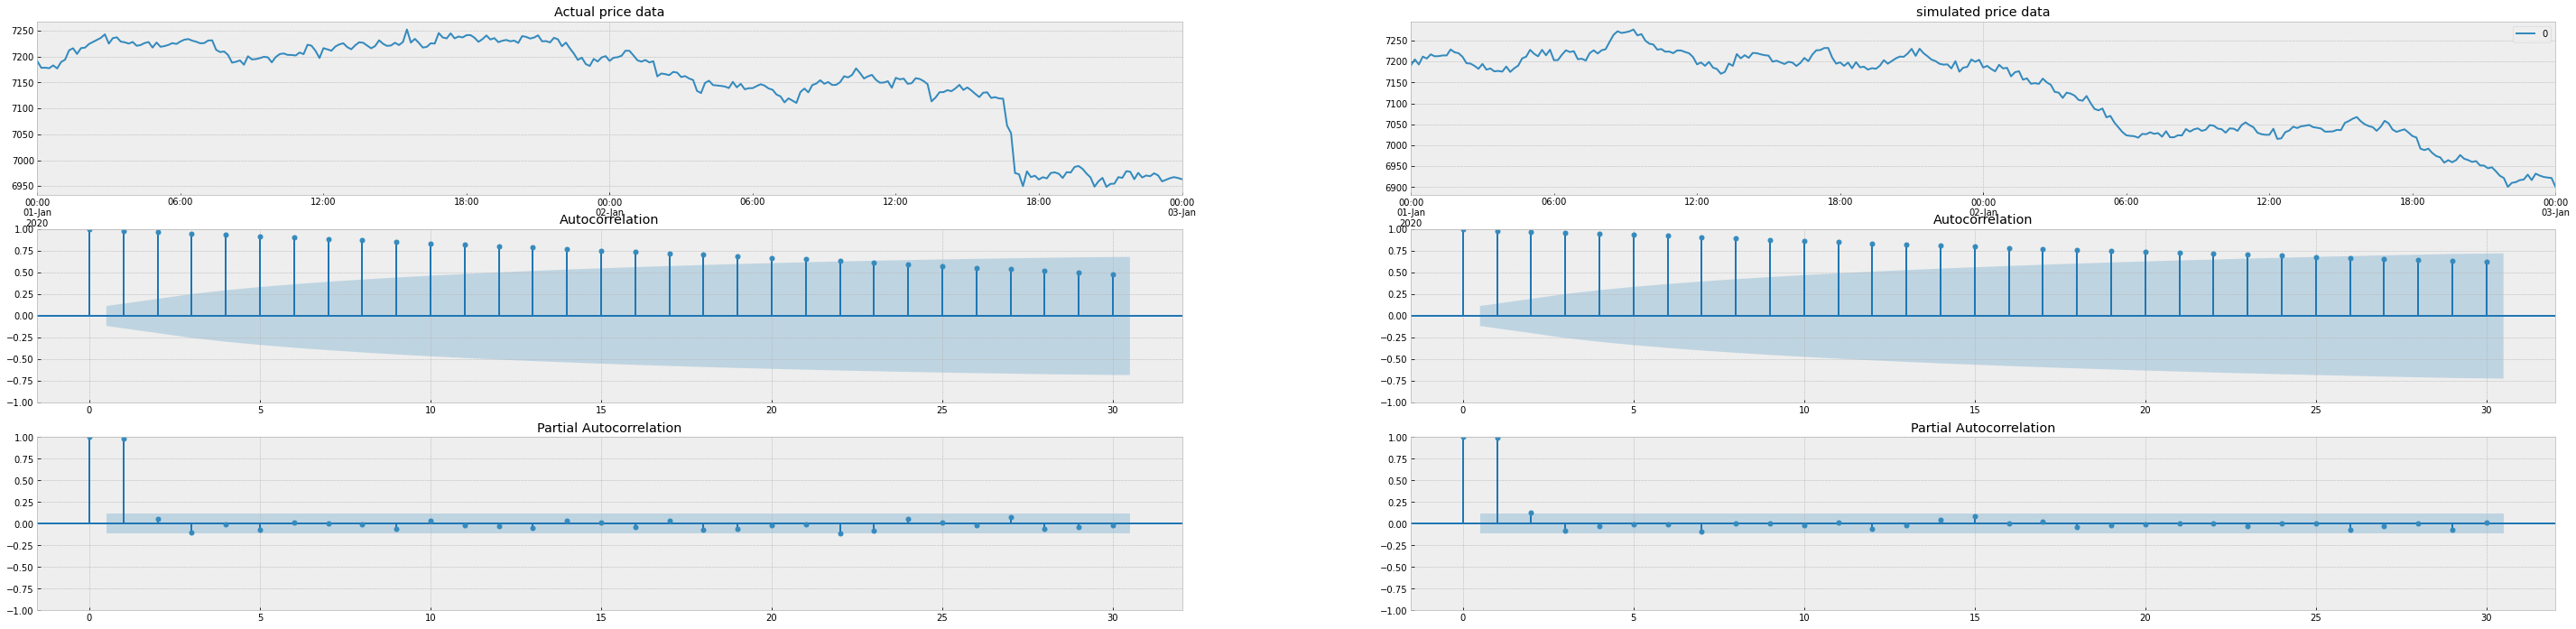

In [13]:
simulate = pd.DataFrame()
simulate[0] = simulated_price_data['close']
simulatedata.Evaluate_performance(dt['close'], simulate, lags=30, isclose = True)

In [14]:
#cách 2
# nhân chol 2 lần
var_close = simulate_multiple_time_series.compute_std(dt1['close'])
mean_close = dt1['close'].mean()
var_open = simulate_multiple_time_series.compute_std(dt1['open'])
mean_open = dt1['open'].mean()
chol = cholesky.cholesky2(dt)
inverse_chol = np.linalg.inv(chol)
# transform = dt1
# transform
transform= simulate_multiple_time_series.transform_forward(dt1, inverse_chol)
transform

,close,open
time,,
2020-01-01 00:00:00+00:00,NaN,NaN
2020-01-01 00:10:00+00:00,-1.199061,-0.127426
2020-01-01 00:20:00+00:00,-0.040793,-1.450286
2020-01-01 00:30:00+00:00,-0.000533,0.127268
2020-01-01 00:40:00+00:00,0.613507,-0.024653
...,...,...
2020-01-02 23:20:00+00:00,0.300979,-1.106465
2020-01-02 23:30:00+00:00,0.428015,0.418607
2020-01-02 23:40:00+00:00,0.320013,0.347811


In [15]:
order_close, seasonal_order_close = simulatedata.get_order(transform['close'][1:])
order_open, seasonal_order_open = simulatedata.get_order(transform['open'][1:])
order_close, seasonal_order_close, order_open, seasonal_order_open

((2, 0, 0), (0, 0, 0, 1), (2, 0, 0), (0, 0, 0, 1))

In [16]:
if sum(seasonal_order_close) == 1: seasonal_order_close = (0, 0, 0, 0)
model_params_close = simulatedata.fit_sarima(transform['close'][1:], order_close, seasonal_order_close)
if sum(seasonal_order_open) == 1: seasonal_order_open = (0, 0, 0, 0)
model_params_open = simulatedata.fit_sarima(transform['open'][1:], order_open, seasonal_order_open)

In [26]:
t_close = simulatedata.simulate_sarima(transform['close'][1:], order_close, seasonal_order_close, model_params_close, len(dt1), 1)
t_open = simulatedata.simulate_sarima(transform['open'][1:], order_open, seasonal_order_open, model_params_open, len(dt1), 1)

In [27]:
transform_x_chol = pd.DataFrame()
transform_x_chol['close'] = t_close[0]
transform_x_chol['open'] = t_open[0]
transform_back = simulate_multiple_time_series.transform_back(transform_x_chol, chol, var_close, mean_close, var_open, mean_open)
transform_back

,open,close
0,-0.000437,-0.002362
1,0.000434,-0.001436
2,-0.002047,0.001598
3,0.002381,0.001121
4,-0.001270,0.000735
...,...,...
284,0.000934,-0.001942
285,-0.000779,-0.000822
286,-0.002425,-0.000405
287,0.001532,-0.000178


In [28]:
transform_back.corr()

,open,close
open,1.000000,-0.061073
close,-0.061073,1.000000


In [25]:
dt1.corr()

,close,open
close,1.000000,-0.093053
open,-0.093053,1.000000


In [29]:
simulated_price_data = pd.DataFrame()
simulated_price_data[0] = simulatedata.construct_price_series(transform_back['close'], dt['close'][0], dt.index[0], freq)
simulated_price_data[1] = simulatedata.construct_price_series(transform_back['open'], dt['open'][0], dt.index[0], freq)
simulated_price_data

,0,1
2020-01-01 00:00:00+00:00,7191.070000,7195.240000
2020-01-01 00:10:00+00:00,7174.083973,7192.092386
2020-01-01 00:20:00+00:00,7163.782612,7195.211131
2020-01-01 00:30:00+00:00,7175.230405,7180.485733
2020-01-01 00:40:00+00:00,7183.277250,7197.583982
...,...,...
2020-01-02 23:20:00+00:00,7083.295726,7048.264547
2020-01-02 23:30:00+00:00,7069.539213,7054.844999
2020-01-02 23:40:00+00:00,7063.729128,7049.352407
2020-01-02 23:50:00+00:00,7060.869013,7032.260455


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


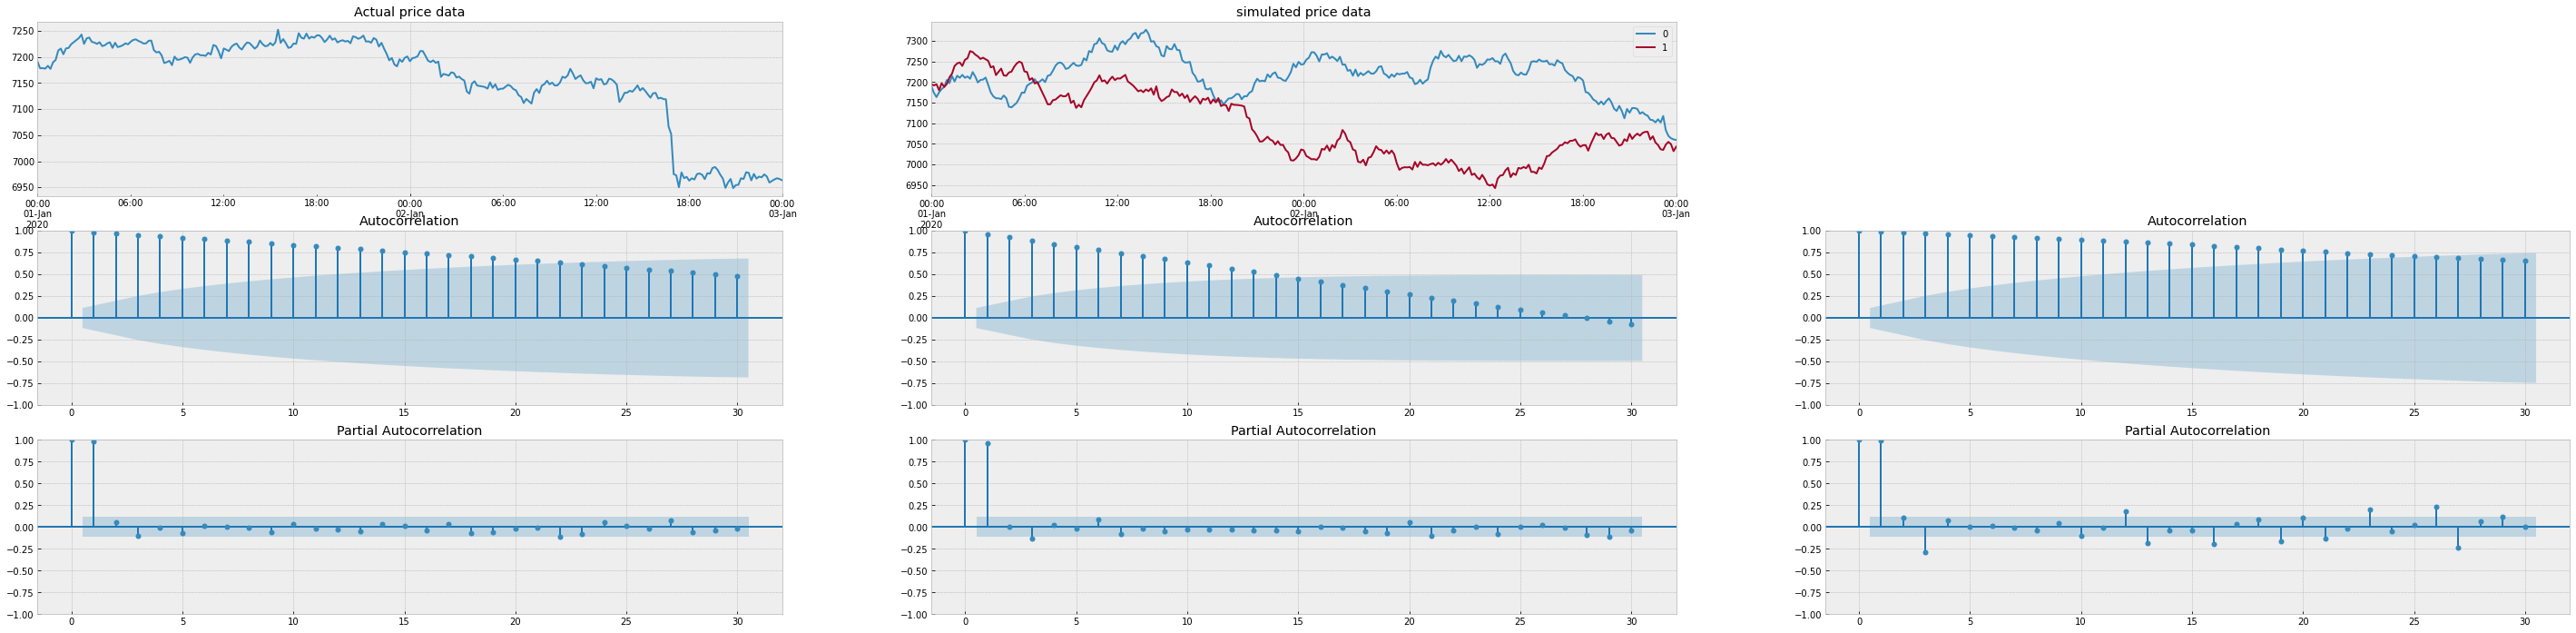

In [30]:
simulatedata.Evaluate_performance(dt['close'], simulated_price_data, lags=30)

In [21]:
simulate_multiple_time_series.simulate_open_and_close(dt).plot()

MemoryError: Unable to allocate 1.09 EiB for an array with shape (157783680000000256,) and data type int64

MemoryError: Unable to allocate 1.09 EiB for an array with shape (157783680000000256,) and data type int64

In [ ]:
# order, seasonal_order = simulatedata.get_order(dt['open'][1:])
# order, seasonal_order

In [ ]:
# if sum(seasonal_order) == 1: seasonal_order = (0, 0, 0, 0)
# model_params = simulatedata.fit_sarima(dt['open'][1:], order, seasonal_order)

In [ ]:
# t = simulatedata.simulate_sarima(dt['open'][1:], order, seasonal_order, model_params, len(dt), 10)
# t

In [ ]:
# simulated_price_data = simulatedata.construct_price_series(t, dt['close'][0], dt.index[0], freq)

In [ ]:
# simulatedata.Evaluate_performance(dt['close'], simulated_price_data, lags=30)